# 禁用GPU
仅个人情况

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import tensorflow as tf
 
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Unet Demo

Author: Ali Khan (alik@robarts.ca)
Modified：Ziyi (zziyifan@uwo.ca)

- 2D 图像分割
- ImageDataGenerators to get the images and segmentations
- Will use padding to avoid size discrepancy差异 at input/output
- Explore how a custom loss can be defined and how this affects the result





In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np 

# 前处理 

##  ImageDataGenerator:  迭代器，带有数据增强功能

Generate batches of tensor image data with real-time data augmentation.

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
datagen_train = ImageDataGenerator(rotation_range=15,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          zoom_range=0.2,
                          rescale=1./255.0)


datagen_test = ImageDataGenerator(rescale=1./255.0)

#### 其他关于ImageDataGenerator的例子

深度学习14 基于ImageDataGenerator的语义分割数据扩充

https://blog.csdn.net/a486259/article/details/116007226

3.目录方式

https://blog.csdn.net/qq_30638831/article/details/84836194

Keras做图片分类（二）：图片的分批读取和数据增强

https://zhuanlan.zhihu.com/p/44673440

# 加载数据

### 利用函数 `flow_from_directory()`，需要如下的文件结构

```
training_data/
   dogs/
      mydog1.png
      mydog2.png
      ...
   cats/
      mycat1.png
      mycat2.png
      ...
test_data/
   dogs/
      mydog101.png
      mydog102.png
      ...
   cats/
      mycat101.png
      mycat102.png
      ...
```

### 固定随机种子，保证图像和标签配套

随机种子的详解

https://blog.csdn.net/ding_programmer/article/details/95097924?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-1-95097924-blog-90572969.pc_relevant_vip_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-1-95097924-blog-90572969.pc_relevant_vip_default&utm_relevant_index=2

In [7]:
image_generator_train = datagen_train.flow_from_directory('brain_2d_seg_data/training',
                                                    target_size=(160,160),
                                                    classes=['images'],
                                                    class_mode=None,  # this just loads the images
                                                    seed=1, # fix the random seed
                                                    color_mode='grayscale',
                                                    batch_size=1)

mask_generator_train = datagen_train.flow_from_directory('brain_2d_seg_data/training',
                                                  target_size=(160,160),
                                                  classes=['brain_masks'],
                                                  class_mode=None,
                                                  seed=1,
                                                  color_mode='grayscale',
                                                  batch_size=1)


image_generator_test = datagen_test.flow_from_directory('brain_2d_seg_data/test',
                                                    target_size=(160,160),
                                                    classes=['images'],
                                                    class_mode=None,
                                                    seed=1,
                                                    color_mode='grayscale',
                                                    batch_size=1)

mask_generator_test = datagen_test.flow_from_directory('brain_2d_seg_data/test',
                                                  target_size=(160,160),
                                                  classes=['brain_masks'],
                                                  class_mode=None,
                                                  seed=1,
                                                  color_mode='grayscale',
                                                  batch_size=1)

Found 915 images belonging to 1 classes.
Found 915 images belonging to 1 classes.
Found 197 images belonging to 1 classes.
Found 197 images belonging to 1 classes.


### 看看加载的图片

用  `next()` 获取图片

In [8]:
#get next batch
image_batch = image_generator_train.next()
mask_batch = mask_generator_train.next()

#examine the output
print(image_batch.shape)


(1, 160, 160, 1)


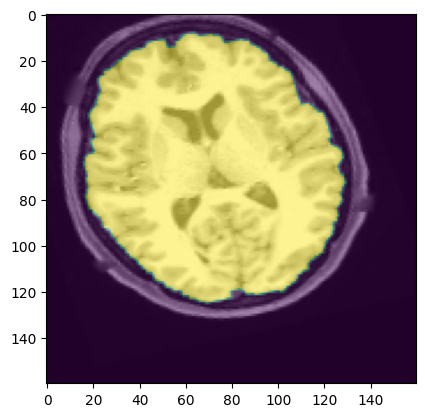

In [9]:
#plot image with mask overlaid
plt.figure()
plt.imshow(image_batch[0,:,:,0],cmap='gray')
plt.imshow(mask_batch[0,:,:,0],alpha=0.5) # transparent

### Use the Dice metric to evaluate performance

In [10]:
from keras import backend as K

def dice_metric(y_true, y_pred):
     y_true_f = K.flatten(y_true)
     y_pred_f = K.flatten(y_pred)
     intersection = K.sum(y_true_f * y_pred_f)
     score = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

     return score

def dice_loss(y_true, y_pred):
    return (1 - dice_metric(y_true, y_pred))


## Create our model 

Use:
- Max-pooling & up-convolutions
- 16 deep in first conv layer
- 2 convolutions in each stage
- 4 skip connections
- padding to get same size outputs


Set each layer to `x`, to make it easier to copy-paste and re-arrange things. 



Conv2D layer
https://keras.io/api/layers/convolution_layers/convolution2d/

In [11]:
img_shape = (160,160,1)
input_layer = keras.layers.Input(img_shape)

x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(input_layer)
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)
out_layer1 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
out_layer2 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
out_layer3 = x
x = keras.layers.MaxPooling2D((2,2))(x)


x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
out_layer4 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(256,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(256,(3,3), padding='same',activation='relu')(x)

x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(128,(2,2), padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer4,x])
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)


x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(64,(2,2), padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer3,x])
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)


x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(32,(2,2), padding='same',activation='relu')(x)


x = keras.layers.Concatenate(axis=3)([out_layer2,x])   # axis specifies along which axis the input will be concatenated
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)

x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(16,(2,2), padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer1,x])
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)

#1x1 conv with sigmoid to get binary classification at each pixel
x = keras.layers.Conv2D(1,(1,1), padding='same',activation='sigmoid')(x)

model = keras.Model(input_layer, x)

###  Compile and visualize it

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_22 (Conv2D)             (None, 160, 160, 1)  17          ['conv2d_21[0][0]']              
                                                                                                  
Total params: 1,940,817
Trainable params: 1,940,817
Non-trainable params: 0
__________________________________________________________________________________________________


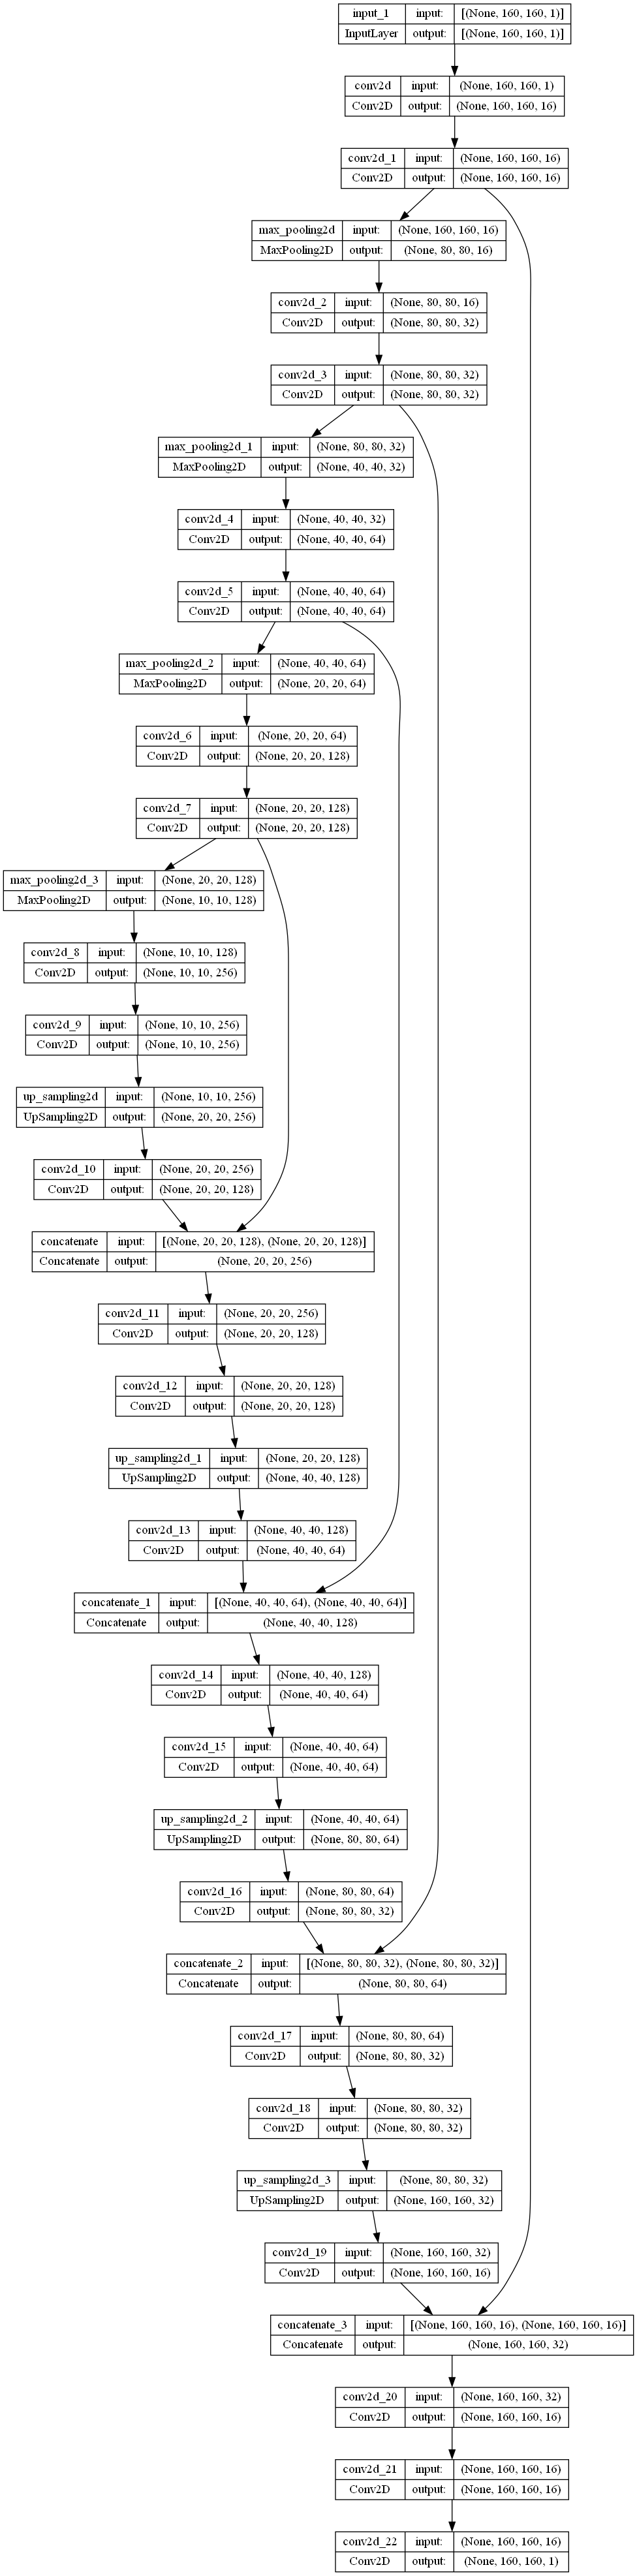

In [12]:

# Compile the model
optimizer = keras.optimizers.Adam()

loss = ['binary_crossentropy',dice_loss]

metrics = ['binary_accuracy',dice_metric]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics) 

# What does the finished model look like?
model.summary()
keras.utils.plot_model(model, show_shapes=True, rankdir='TD')

## Fit the model

The fit() function takes x and y -- we want to pass the image and mask  correspondingly.

But since we are using generators, we need the output of the generator to be: `(image, mask)`

We can create this behaviour by using `zip()` to zip together the image and mask generators. 




In [13]:
# combine generators into one which yields both image and masks
train_generator = zip(image_generator_train, mask_generator_train)
test_generator = zip(image_generator_test, mask_generator_test)

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=10)


Epoch 1/10
100/100 [==============================] - 13s 123ms/step - loss: 0.1769 - binary_accuracy: 0.9267 - dice_metric: 0.8579
Epoch 2/10
100/100 [==============================] - 11s 113ms/step - loss: 0.0367 - binary_accuracy: 0.9748 - dice_metric: 0.9679
Epoch 3/10
100/100 [==============================] - 11s 109ms/step - loss: 0.0766 - binary_accuracy: 0.9641 - dice_metric: 0.9424
Epoch 4/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0352 - binary_accuracy: 0.9763 - dice_metric: 0.9701
Epoch 5/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0438 - binary_accuracy: 0.9739 - dice_metric: 0.9660
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.0265 - binary_accuracy: 0.9781 - dice_metric: 0.9784
Epoch 7/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0230 - binary_accuracy: 0.9794 - dice_metric: 0.9810
Epoch 8/10
100/100 [==============================] - 11s 107ms/step - loss:

Plot the loss and metrics on training data

<AxesSubplot: >

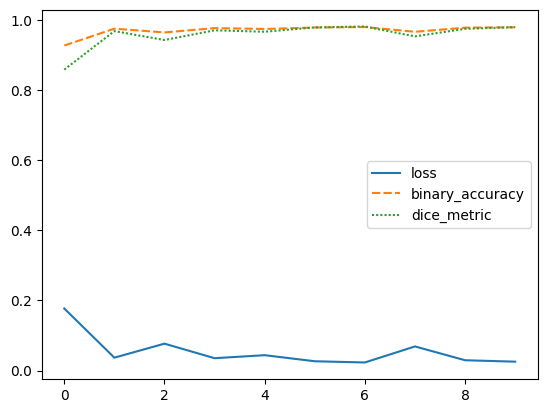

In [14]:
#plot loss and metrics
import pandas as pd
import seaborn as sns
df = pd.DataFrame(history.history)
sns.lineplot(data=df)


Evaluate the metrics on the test data

In [15]:
metrics = model.evaluate(test_generator,steps=197,return_dict=True)
print(metrics)

197/197 [==============================] - 7s 32ms/step - loss: 0.0231 - binary_accuracy: 0.9910 - dice_metric: 0.9800
{'loss': 0.023090995848178864, 'binary_accuracy': 0.9909719824790955, 'dice_metric': 0.9799607396125793}


Let's take a look at some results for the test dataset

1/1 [==============================] - 0s 35ms/step


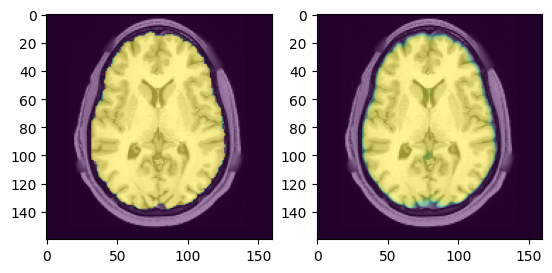

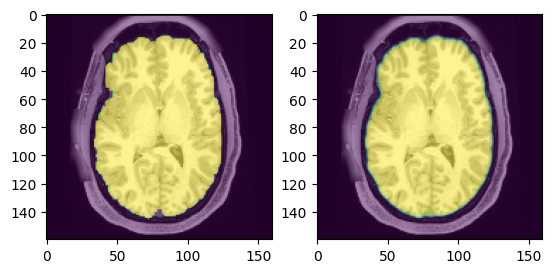

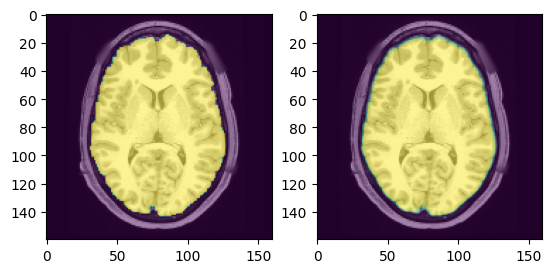

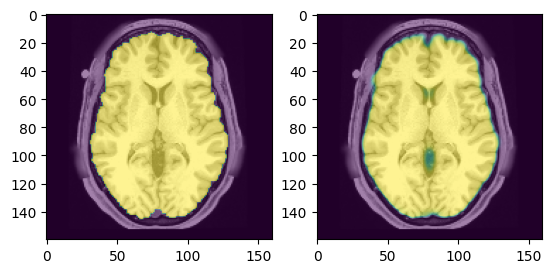

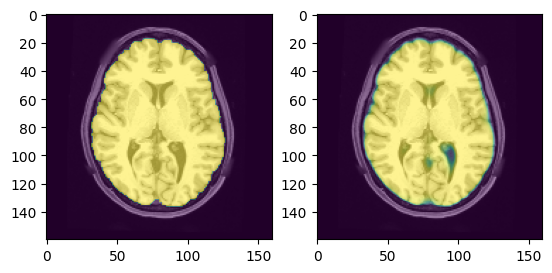

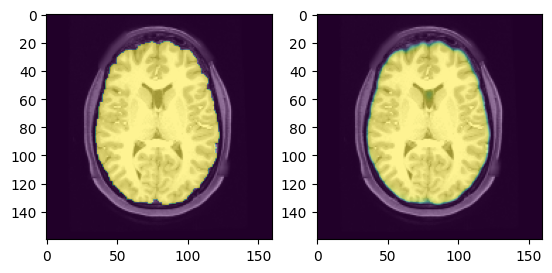

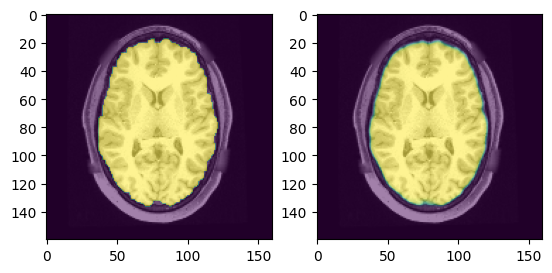

In [16]:
#plot some examples from the test set

for sample,(image,mask) in enumerate(test_generator):
  
  predicted = model.predict(image)

  plt.figure()

  plt.subplot(1,2,1)
  plt.imshow(np.squeeze(image),cmap='gray')
  plt.imshow(np.squeeze(mask),alpha=0.5)
  
  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(image),cmap='gray')
  plt.imshow(np.squeeze(predicted),alpha=0.5)
  

  if sample > 5:
    break
  